# Machine learning using scikit-learn
> Best practices made simple with pipelines

In this notebook, we demonstrate the usage of pipelines to promote best practices in ML in python.  We'll make sure that all of our pre-processing steps are included within the cross validation training loop, measure performance using cross validation, and make sure to use literate programming practices to share our work.

# Technical objective
Our technical objective here is to predict whether a penguin is male or female given its other distinguishing features. TEST

In [1]:
#tables and visualizations
import pandas as pd
import numpy as np
import seaborn as sns

#machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report

# Load the data
In this example, we'll use Allison Horst's penguins dataset.  Although this is normally used in R, we grab the csv from the penguins [GitHub repo](https://github.com/allisonhorst/palmerpenguins).  More information on the dataset is available on the introduction page [here.](https://allisonhorst.github.io/palmerpenguins/articles/intro.html)

In [26]:
#load the data and learn a bit
peng_data = pd.read_csv('https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins.csv')
peng_data.rename(columns={'sex':'is_male'}, inplace=True)
peng_data['is_male'] = peng_data['is_male'].replace({'male':'m', 'female':'f'})
display(peng_data.head())
peng_data.info()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,is_male,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,m,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,f,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,f,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,f,2007


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   is_male            333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB


# Data cleaning and EDA
We can now explore our data.  We leave this exercise to the reader.  For now, we can observe that there are a few NA values which will likely need imputation.  We'll wait for this step so that we can put it within our training loop.  For now, we'll just drop all of the sex NAs out of the dataframe.

In [9]:
peng_data = peng_data.dropna(subset=['is_male'])

In [10]:
peng_data.shape

(333, 8)

This set of dimensions is expected.

# ?
?? What is the purpose of this section?

In [11]:
class_column = 'is_male'
random_seed = 2435

X_train, X_test, y_train, y_test = train_test_split(peng_data.drop(columns=class_column), peng_data[class_column],
                                                   test_size=0.25, random_state=random_seed, stratify=peng_data[class_column])

Quick sanity check to make sure that everything seems OK:

In [12]:
# X Train
print('On X train: ')
print('X train dimensions: ', X_train.shape)
display(X_train.head())

# X test
print('\nOn X test: ')
print('X test dimensions: ', X_test.shape)
display(X_test.head())

On X train: 
X train dimensions:  (249, 7)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
101,Adelie,Biscoe,41.0,20.0,203.0,4725.0,2009
260,Gentoo,Biscoe,43.3,14.0,208.0,4575.0,2009
142,Adelie,Dream,32.1,15.5,188.0,3050.0,2009
155,Gentoo,Biscoe,50.0,15.2,218.0,5700.0,2007
136,Adelie,Dream,35.6,17.5,191.0,3175.0,2009



On X test: 
X test dimensions:  (84, 7)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
308,Chinstrap,Dream,42.5,16.7,187.0,3350.0,2008
120,Adelie,Torgersen,36.2,17.2,187.0,3150.0,2009
206,Gentoo,Biscoe,46.5,14.4,217.0,4900.0,2008
106,Adelie,Biscoe,38.6,17.2,199.0,3750.0,2009
99,Adelie,Dream,43.2,18.5,192.0,4100.0,2008


In [13]:
# X Train
print('On y train: ')
print('y train dimensions: ', y_train.shape)
display(y_train.head())

# X test
print('\nOn y test: ')
print('y test dimensions: ', y_test.shape)
display(y_test.head())

On y train: 
y train dimensions:  (249,)


101    m
260    f
142    f
155    m
136    f
Name: is_male, dtype: object


On y test: 
y test dimensions:  (84,)


308    f
120    f
206    f
106    f
99     m
Name: is_male, dtype: object

I love a good sanity check.  Here, we can see that the ratios of the split are about correct.  We can also observe that the indices match (for example, between X and y train).  These are all good indicators.

# Establish training pipeline
?? What do you think we're doing here?  Add a brief description of the goals of the following section.  Add some comments after the pound symbol in the cells below.

In [27]:
#
cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                               ('onehot_cat', OneHotEncoder(drop='if_binary'))])

#
num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
                               ('scale_num', StandardScaler())])     

In [28]:
#
preproc = ColumnTransformer([('cat_pipe', cat_pipeline, make_column_selector(dtype_include=object)),
                             ('num_pipe', num_pipeline, make_column_selector(dtype_include=np.number))],
                             remainder='passthrough')

In [29]:
#
pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', LogisticRegression(penalty='elasticnet', solver='saga', tol=0.01))])

#visualization for steps
with config_context(display='diagram'):
    display(pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000197F88922E0>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000197F8892340>)])),
                ('mdl',
                 LogisticRegression(penalty='elasticnet', solver='saga',
                                    tol=0.01))])

# Cross-validation with hyperparameter tuning
?? What is this section doing?  Use your best debugging skills if you don't know what `np.linspace` or `np.logspace` do (e.g., make a new cell, pop the code in there, run it, and see what it returns).  You might need to run these cells and examine the results if it's ambiguous from the variable names and parallels with tidymodels what is occurring.

?? What are C and l1_ratio, do you think?  Note that the syntax `mdl__` prefixes these variables just for scikit-learn implementation.  You can take a look at the Logistic Regression documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for clarification.

In [30]:
#
tuning_grid = {'mdl__l1_ratio' : np.linspace(0,1,5),
               'mdl__C': np.logspace(-1, 6, 3) }
#
grid_search = GridSearchCV(pipe, param_grid = tuning_grid, cv = 5, return_train_score=True)

In [33]:
np.linspace(0,1,5)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [31]:
#
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000197F88922E0>),
                                                                        ('num_pipe',
                                                

In [34]:
#
print(grid_search.best_score_)
grid_search.best_params_

0.9158367346938775


{'mdl__C': 316.22776601683796, 'mdl__l1_ratio': 0.0}

In [32]:
#
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mdl__C,param_mdl__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.014150,0.004824,0.003916,0.000860,0.1,0,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.0}",0.90,0.90,0.92,...,0.903673,0.014628,11,0.899497,0.909548,0.909548,0.904523,0.905,0.905623,0.003740
1,0.009758,0.000619,0.003810,0.000646,0.1,0.25,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.25}",0.90,0.90,0.92,...,0.903673,0.014628,11,0.889447,0.909548,0.899497,0.919598,0.900,0.903618,0.010212
2,0.009944,0.000394,0.003714,0.000740,0.1,0.5,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.5}",0.92,0.88,0.90,...,0.899837,0.039756,13,0.894472,0.904523,0.884422,0.909548,0.900,0.898593,0.008660
3,0.010731,0.000625,0.003524,0.000774,0.1,0.75,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.75}",0.92,0.88,0.88,...,0.891673,0.023625,14,0.904523,0.909548,0.899497,0.914573,0.895,0.904628,0.006959
4,0.011326,0.002675,0.004100,0.000957,0.1,1,"{'mdl__C': 0.1, 'mdl__l1_ratio': 1.0}",0.88,0.88,0.90,...,0.891673,0.015432,14,0.899497,0.884422,0.899497,0.899497,0.885,0.893583,0.007246
5,0.011121,0.001330,0.004105,0.000402,316.228,0,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.90,0.90,0.92,...,0.915837,0.023016,1,0.929648,0.929648,0.939698,0.939698,0.915,0.930739,0.009062
6,0.011879,0.000955,0.004307,0.000775,316.228,0.25,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.90,0.90,0.92,...,0.915837,0.023016,1,0.929648,0.929648,0.939698,0.939698,0.915,0.930739,0.009062
7,0.016005,0.004998,0.005271,0.000995,316.228,0.5,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.90,0.90,0.92,...,0.915837,0.023016,1,0.929648,0.929648,0.939698,0.939698,0.915,0.930739,0.009062
8,0.012298,0.001585,0.004680,0.001441,316.228,0.75,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.90,0.90,0.92,...,0.915837,0.023016,1,0.929648,0.929648,0.939698,0.939698,0.915,0.930739,0.009062
9,0.010529,0.000385,0.003518,0.000484,316.228,1,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.90,0.90,0.92,...,0.915837,0.023016,1,0.929648,0.929648,0.939698,0.939698,0.915,0.930739,0.009062


# Final fit
The final fit here is already present in the generated model due to the way we set our parameters in the grid search.  If we want to look at the performance, we can do so.  Here is a non-helpful description of the best model:

In [21]:
grid_search.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000197F8494E80>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                            

# Variable importance
Now we assess the importance in the selected model to reveal any potential insights.

In [22]:
grid_search.classes_

array(['f', 'm'], dtype=object)

In [23]:
vip = grid_search.best_estimator_['mdl'].coef_[0]
vip

array([ 3.57865866, -2.42229011, -1.48219984, -0.39943444,  0.36446792,
       -0.29086478,  2.62893742,  3.12592295, -0.12834205,  4.0029126 ,
        0.1623278 ])

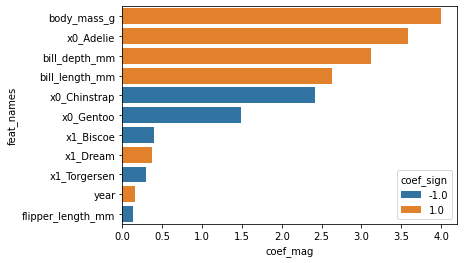

In [35]:
#get names in correct preproc order
cat_names = grid_search.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names()
num_names = grid_search.best_estimator_.named_steps['preproc'].transformers_[1][2]

#create df with vip info
coef_info = pd.DataFrame({'feat_names':np.hstack([cat_names, num_names]), 'vip': vip})

#get sign and magnitude information
coef_info = coef_info.assign(coef_mag = abs(coef_info['vip']),
                             coef_sign = np.sign(coef_info['vip']))

#sort and plot
coef_info = coef_info.set_index('feat_names').sort_values(by='coef_mag', ascending=False)
sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False);

# Performance metrics on test data

In [25]:
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           f       0.89      0.93      0.91        42
           m       0.93      0.88      0.90        42

    accuracy                           0.90        84
   macro avg       0.91      0.90      0.90        84
weighted avg       0.91      0.90      0.90        84



Here, we can see the performance of the model, which is pretty nice!  We can also look into different scores specifically for more insight into the performance.